<a href="https://colab.research.google.com/github/ManojKesani/crowdhuman/blob/master/Crowd_human.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installing Tensorflow 2.2.0 and setting up Object Detection API

In [ ]:
!pip install imagesize
!pip install -U --pre tensorflow=="2.2.0"

In [ ]:
import tensorflow as tf
print (tf.__version__) 

In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

#Preparing workspace Crowdhuman Data


    └──Workspace
      └──crowdhuman
        └──resourses
          └────────────generate_tfrecord.py
          └────────────label_map.txt
          └────────────pipeline.config
      └──models
        └────────────resnet(currently training)
      └──Train (Training data)
        └────────────Images
        └────────────annotations_train.odgt
      └──val
        └────────────Images
        └────────────annotations_val.odgt
      └──exported_model
      └──pretrained_models


In [ ]:
%%bash
mkdir workspace
cd /content/workspace/

mkdir /content/workspace/train
mkdir /content/workspace/val
mkdir /content/workspace/models
mkdir /content/workspace/pretrained_models
mkdir /content/workspace/exported_model

cd /content/workspace/models
mkdir /content/workspace/models/resnet

###unzip validation images into /content/workspace/val/Images and validation annotations from Drive


In [ ]:
cd /content/workspace/val

In [ ]:
!unzip /content/drive/My\ Drive/Crowd/CrowdHuman_val.zip
!cp /content/drive/My\ Drive/Crowd/annotation_val.odgt annotation_val.odgt 

###unzip train images into /content/workspace/val/Images and train annotations from Drive

In [24]:
cd /content/workspace/train

/content/workspace/train


In [ ]:
#unzip train images into /content/workspace/val/Images and train annotations from Drive

!unzip /content/drive/My\ Drive/Crowd/CrowdHuman_train01.zip
!unzip /content/drive/My\ Drive/Crowd/CrowdHuman_train02.zip
!unzip /content/drive/My\ Drive/Crowd/CrowdHuman_train03.zip

!cp /content/drive/My\ Drive/Crowd/annotation_train.odgt annotation_train.odgt

###Downloading resourses form my github

In [ ]:
cd /content/workspace

In [27]:
#getting resourses from my Github
#generate_tfrecord.py-------to convert csv annotations to tfrecord
#label_map.pbtxt------------map containg 'person' , 'head' labels
#pipeline config------------training config for resnet_50

!git clone https://github.com/ManojKesani/crowdhuman.git

fatal: destination path 'crowdhuman' already exists and is not an empty directory.


###Downloading ssd_resnet50 pretrained weights from ModelZoo


In [ ]:
cd /content/workspace/pretrained_models

In [ ]:

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf /content/workspace/pretrained_models/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

###Setting up training pipeline.config

In [ ]:
cd /content/workspace/models/resnet

In [34]:
!cp /content/workspace/crowdhuman/resources/pipeline.config pipeline.config 

###Setting up train and val paths

In [45]:

TRAIN_IMG_FOLDER_PATH = '/content/workspace/train/Images'
TRAIN_ANNO_PATH = '/content/workspace/train/annotation_train.odgt'

VAL_IMG_FOLDER_PATH = '/content/workspace/val/Images'
VAL_ANNO_PATH = '/content/workspace/val/annotation_val.odgt'


LABEL_MAP_PATH = '/content/workspace/crowdhuman/resources/label_map.pbtxt'

# PIPELINE_CONFIG_PATH = '/content/workspace/crowdhuman/resources/pipeline.config'
# TFRECORD_GENERATER_PATH = '/content/workspace/crowdhuman/resources/generate_tfrecord.py'

# ODGT_to_CSV
    
    This function converts odgt annotations into pandas dataframe and returns it.
    Inputs
          ANNO_PATH         - path to annotations in odgt format
          IMG_FOLDER_PATH   - path to folder containg the images
    Output
          csv_df            - Pandas data frame in csv format

In [ ]:
cd /content/workspace

In [9]:
import cv2
import json
import numpy as np
import imagesize
import pandas as pd

In [44]:
def odgt_to_csv(ANNO_PATH, IMG_FOLDER_PATH):
  csv_list = []

  with open(ANNO_PATH, 'r+') as f:
    datalist = f.readlines()


  for i in np.arange(len(datalist)):

    print(f'Working on image : {i+1}/{len(datalist)}')

    adata = json.loads(datalist[i])
    gtboxes = adata['gtboxes']

    # Reading annotations with label 'person' and adding them to csv list
    for gtbox in gtboxes:
      if gtbox['tag']=='person':
        
        # getting filename
        id = adata['ID']

        # print(gtbox,id)

        filename = f'{IMG_FOLDER_PATH}/{id}.jpg'

        # reading image to get width and height
        width, height = imagesize.get(f'{IMG_FOLDER_PATH}/{id}.jpg')

        # label
        label = 'person'

        # extracting visuable bounding boxes and changing them from 
        # XYWH to xmin,ymin,xmax,ymax
        xmin = gtbox['vbox'][0]
        ymin = gtbox['vbox'][1]
        xmax = gtbox['vbox'][0] + gtbox['vbox'][2]
        ymax = gtbox['vbox'][1] + gtbox['vbox'][3]

        # appending to the output list
        body = (filename, width, height, 'person', xmin, ymin, xmax, ymax)
        csv_list.append(body)

        # appending head BBox if it exists
        if len(gtbox['head_attr']):

          if  not gtbox['head_attr']['ignore'] :
            # extracting visuable bounding boxes and changing them from 
            # XYWH to xmin,ymin,xmax,ymax
            xmin = gtbox['hbox'][0]
            ymin = gtbox['hbox'][1]
            xmax = gtbox['hbox'][0] + gtbox['hbox'][2]
            ymax = gtbox['hbox'][1] + gtbox['hbox'][3]

            # appending to the output list
            head = (filename,width,height,'head',xmin,ymin,xmax,ymax)
            csv_list.append(head)

  column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
  csv_df = pd.DataFrame(csv_list, columns=column_name)

  return csv_df

#Preparing Data for training

###Generating CSV files for training and val

In [ ]:
train_csv = odgt_to_csv(TRAIN_ANNO_PATH,TRAIN_IMG_FOLDER_PATH)
train_csv.to_csv(r'/content/workspace/train/train.csv',index = False)

val_csv = odgt_to_csv(VAL_ANNO_PATH,VAL_IMG_FOLDER_PATH)
val_csv.to_csv(r'/content/workspace/val/val.csv',index = False)

###Generating TFRecords for train and val

In [51]:
!python /content/workspace/crowdhuman/resources/generate_tfrecord.py --csv_input=/content/workspace/train/train.csv  --output_path=/content/workspace/train/train.record
!python /content/workspace/crowdhuman/resources/generate_tfrecord.py --csv_input=/content/workspace/val/val.csv  --output_path=/content/workspace/val/val.record

2020-09-29 21:00:59.628759: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Successfully created the TFRecords: /content/workspace/train/train.record


#Training Resnet_50 model

In [ ]:
!python /content/models/research/object_detection/model_main_tf2.py --model_dir=/content/workspace/models/resnet --pipeline_config_path=/content/workspace/models/resnet/pipeline.config

###Ploting training results with tensorboard

In [ ]:
# learning_rate_base: 0.02999999910593033 total_steps: 5000 warmup_steps: 500
%load_ext tensorboard
%tensorboard --logdir /content/workspace/models/resnet 

#Exporting trained model

In [ ]:
!python /content/models/research/object_detection/exporter_main_v2.py --input_type image_tensor --pipeline_config_path /content/workspace/models/resnet/pipeline.config --trained_checkpoint_dir /content/workspace/models/resnet --output_directory /content/workspace/exported_model

#Inference with my trained model

In [ ]:
cd /content/workspace

In [ ]:
#Downloading traained model
#Trained model can be forund at https://drive.google.com/file/d/1-WHSoeulyKQ_A2y06-wrE8D1Xlr7T8EE/view?usp=sharing

!gdown --id 1-WHSoeulyKQ_A2y06-wrE8D1Xlr7T8EE
!unzip resnet_50_crowd.zip

In [40]:
import time
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

PATH_TO_SAVED_MODEL = "/content/workspace/saved_model"

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))



Loading model...Done! Took 15.927922010421753 seconds


In [60]:
#Running inference on few images from validation 
IMAGE_PATHS=[
             '/content/workspace/val/Images/273271,104ec00067d5b782.jpg',
             '/content/workspace/val/Images/273271,14f00058acfe2f.jpg',
             '/content/workspace/val/Images/273271,1f29200037af8acb.jpg',
             '/content/workspace/val/Images/273271,22b030001c7be4ec.jpg',
             '/content/workspace/val/Images/273271,2720e0009fd8f9d2.jpg'             
             ]

LABEL_MAP_PATH = '/content/workspace/crowdhuman/resources/label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(LABEL_MAP_PATH, use_display_name=True)

Running inference for /content/workspace/val/Images/273271,104ec00067d5b782.jpg... Done
Running inference for /content/workspace/val/Images/273271,14f00058acfe2f.jpg... Done
Running inference for /content/workspace/val/Images/273271,1f29200037af8acb.jpg... Done
Running inference for /content/workspace/val/Images/273271,22b030001c7be4ec.jpg... Done
Running inference for /content/workspace/val/Images/273271,2720e0009fd8f9d2.jpg... Done


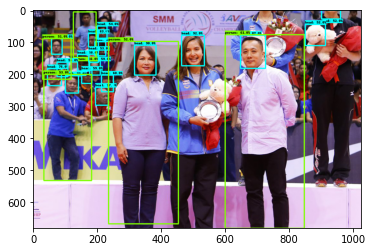

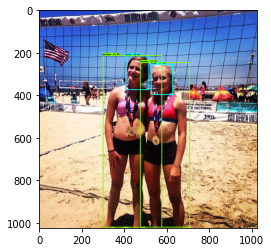

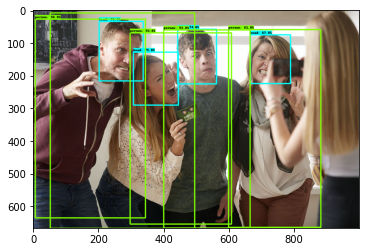

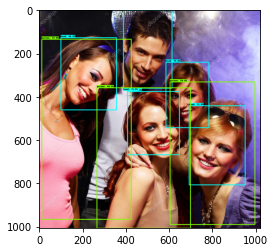

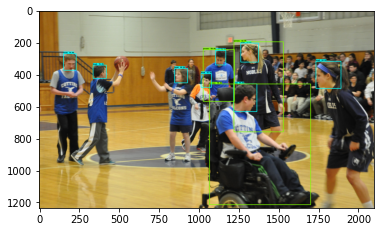

In [61]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))


for image_path in IMAGE_PATHS:

    print('Running inference for {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(image_path)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.50,
          agnostic_mode=False)

    plt.figure()
    plt.imshow(image_np_with_detections)
    print('Done')
plt.show()
